<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# CNNs to Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordigns
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --single-branch --branch cboulay/macaque_pfc --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta1
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell, reset_keras
%load_ext tensorboard

In [2]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'monkey_pfc'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' )} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare data from one session
TODO: Explain data.

### Load the data
Let's use a helper function from the repo to load the data.
You can see the code for `load_macaque_pfc` [here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/utils/fileio.py)
(TODO: Point to line number).

In [3]:
from data.utils.fileio import load_macaque_pfc

SESS_ID = 'sra3_1_m_074_0001'
X, Y, ax_info = load_macaque_pfc(datadir, SESS_ID, x_chunk='spikerates', zscore=True)
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

# Stack LFP data on the channel dimension.
# lfp, _, _ = load_macaque_pfc(datadir, SESS_ID, x_chunk='analogsignals', zscore=True)
# X = np.concatenate((X, lfp), axis=2)

Found 884 trials, 170 timestamps (-0.2 to 1.49 at 100.0 Hz), 32 channels


### Get baseline accuracy

Next we will use "shallow" machine learning techniques to train a model to predict intended saccade direction.

A good first approach would be to use multi-class LDA. Given the number of features (timestamps * channels), LDA is likely to over-fit. We can use regularization. However, sk-learn's LDA regularization relies on the `'eigen'` solver which can run out of memory when operating on very large feature matrices. You can try the cell below, but it may not work depending on how many channels and timestamps we have. sk-learn probably has other mechanisms to regularize LDA, but we'll instead use a different ML algorithm below.

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold


lda = LDA(shrinkage='auto', solver='eigen')
splitter = StratifiedKFold(n_splits=10)

y_preds = []
y_true = []
fold_ix = 0
for trn, tst in splitter.split(X, Y):
    fold_ix += 1
    print("Fold {}".format(fold_ix))
    lda.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(lda.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 60.40723981900452


Instead of LDA, we'll use Logistic Regression. sk-learn's regularization scheme for logistic regression is more robust than for LDA. This is a CPU-intensive task and is a bit slow on Colab.

Note: Though 'Logistic Regression' has 'regression' in the name, it's actually a classification algorithm.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 500
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=N_SPLITS)

y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 60.40723981900452


The accuracy using shallow methods is around 58-62%. Is this good?

There are 8 different classes in the data. Chance accuracy _should_ be 12.5%. However, condition-pairs were presented in blocks, so a classifier that could simply identify "block" (e.g. by heavily weighting transient neurons) would achieve ~50% accuracy. The best way to know is to run the classifier again using only data available before any stimulus was presented, and again using only data after the stimulus was presented but before the cue indicated the correct stimulus was presented.

In [6]:
b_times = ax_info['timestamps'] < 0
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-trial data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 2


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 3


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 4


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

Fold 5


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 6


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs 

Fold 7


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 8


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 9


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 10


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


8-class accuracy using pre-trial data only: 28.167420814479637%


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [7]:
b_times = ax_info['timestamps'] < 0.250
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-cue data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 2


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 3


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 4


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 5


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 6


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 7


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 8


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 9


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 10


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


8-class accuracy using pre-cue data only: 39.705882352941174%


/home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Without any stimulus information at all, decoder accuracy was ~25%. Including neural data after the target-distractor pair appeared, but before the cue appeared (i.e. before the monkey had enough information to know the correct target), decoder accuracy was ~40%. Our decoder using all of the data up to the imperative cue had an accuracy of 58-62%, which is much higher than these 'baseline' values. While this accuracy is not good enough for an effective BCI, it does suggest that the model learned something about the relationship between neural activity and intended saccade direction.

### Prepare data for deep learning
See 02_02 notebook for explanation.

One major difference is that here we are using [data augmentation](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/). Briefly, we are using a time-domain window containing only a subset of our total samples, and the start of the window (`t_offset`) is random on every step.

In [8]:
from sklearn.model_selection import train_test_split

def get_ds_train_valid(X, Y, p_train=0.8, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        x_dat = tf.expand_dims(x_dat, -1)  # Prepare as an image, with only 1 colour channel.
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=p_train)
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_fn)
    ds_train = ds_train.shuffle(int(n_trials * p_train) + 1).batch(batch_size, drop_remainder=True)  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train
    
PTRAIN = 0.8
BATCH_SIZE = 10
MAX_OFFSET = 30
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, p_train=PTRAIN, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)

## Create our model
Our model objective is to transform timeseries data into probabilities of each class.



In [9]:
# EEGNet-like model. https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
# See explanation of depthwise and separable convs here:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers


def make_model(T, C,
               n_temporal_filters=8,
               kern_length_1=23, downsamp_1=3,
               D=2,
               n_pointwise_filters=44, kern_length_2=11, downsamp_2=3,
               n_last_filters=16, kern_length_3=6, downsamp_3=2,
               norm_rate=0.2, dropout_rate=0.4, l2_reg=0.001):
    """
    Create EEGNet-like model.
    :param T: Number of time-steps in input
    :param C: Number of channels in input
    :param n_temporal_filters: We need enough temporal filters to capture all within-channel patterns * scales.
     e.g. oscillations at different freqs, evoked potentials, transition between bistable firing rates.
    :param kern_length_1: Temporal filter kernel length should be long enough to capture slow features.
     e.g. 2 Hz oscillations or long ERPs req ~500 msec
    :param downsamp_1: First downsample factor. If we started with 2-seconds at 40 Hz, a 4x downsample yields 2-seconds at 10-Hz.
    :param D: Spatial_filters per temporal filter.
    :param n_pointwise_filters: Output of transformation across (n_temporal_filters * D filters) filters
    :param kern_length_2: Length of kernel for second time-domain convolution.
    :param downsamp_2:
    :param n_last_filters:
    :param kern_length_3:
    :param downsamp_3:
    :param norm_rate: kernel_constraint max_norm parameter in final Dense layer.
    :param dropout_rate:
    :param l2_reg:
    :return: model
    """

    model = tf.keras.models.Sequential([
        # 2-D filter has len=1 in the 'space'/'channels' dimension. Effectively the same filter is used in all channels.
        layers.Conv2D(n_temporal_filters, (kern_length_1, 1), padding='same',
                      input_shape=(T - MAX_OFFSET, C, 1),
                      kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                      use_bias=False),
        layers.BatchNormalization(axis=1),
        # First layer yields output of a bank of time-domain filters.
        # Next we apply spatial filters (1, C). There are D spatial filters for each temporal filter.
        layers.DepthwiseConv2D((1, C), use_bias=False,
                               depth_multiplier=D,
                               kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_constraint=max_norm(1.)),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_1, 1)),
        layers.Dropout(dropout_rate),
        
        layers.SeparableConv2D(n_pointwise_filters, (kern_length_2, 1), padding='same',
                               use_bias=False),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_2, 1)),
        layers.Dropout(dropout_rate),
        
        
#         layers.Conv2D(n_last_filters, (kern_length_3, 1), 
#                       kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
#                       padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('elu'),
#         layers.AveragePooling2D((downsamp_3, 1)),
#         layers.Dropout(dropout_rate),
        
        layers.Flatten(),
        layers.Dense(8, kernel_constraint=max_norm(norm_rate)),
        layers.Activation('softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

model = make_model(X.shape[1], X.shape[2])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 140, 32, 8)        184       
_________________________________________________________________
batch_normalization (BatchNo (None, 140, 32, 8)        560       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 140, 1, 16)        512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 140, 1, 16)        560       
_________________________________________________________________
activation (Activation)      (None, 140, 1, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 46, 1, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 1, 16)         0

### Train the model
We use 100 epochs which is probably overkill for this particular dataset.
However, we've put in some guards against over-fitting so we might still expect this to perform well on the validation set.

In [10]:
# Callback to save only the best model.
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(datadir / 'converted' / (SESS_ID + '_model_best.h5')),
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
# Train model
N_EPOCHS = 200
history = model.fit(x=ds_train,  
                    epochs=N_EPOCHS, 
                    validation_data=ds_valid,
                    callbacks=callbacks,
                    verbose=1)
reset_keras(model)
# Download 'best' model anytime with
# files.download(datadir / 'converted' / (SESS_ID + '_model_best.h5'))

W0806 10:32:45.522740 139720902559552 deprecation.py:323] From /home/chad/miniconda3/envs/indl/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
63/70 [==========================>...] - ETA: 0s - loss: 1.6836 - accuracy: 0.3270
Epoch 00001: val_accuracy improved from -inf to 0.46893, saving model to /media/chad/STORE/Tools/Neurophys/IntracranialNeurophysDL/data/monkey_pfc/converted/sra3_1_m_074_0001_model_best.h5
70/70 [==============================] - 5s 73ms/step - loss: 1.6461 - accuracy: 0.3386 - val_loss: 1.7703 - val_accuracy: 0.4689
Epoch 2/200
69/70 [============================>.] - ETA: 0s - loss: 1.1539 - accuracy: 0.4884
Epoch 00002: val_accuracy improved from 0.46893 to 0.56497, saving model to /media/chad/STORE/Tools/Neurophys/IntracranialNeurophysDL/data/monkey_pfc/converted/sra3_1_m_074_0001_model_best.h5
70/70 [==============================] - 1s 8ms/step - loss: 1.1523 - accuracy: 0.4886 - val_loss: 1.3873 - val_accuracy: 0.5650
Epoch 3/200
62/70 [=========================>....] - ETA: 0s - loss: 1.0470 - accuracy: 0.5419
Epoch 00003: val_accuracy improved from 0.56497 to 0.59322, saving model to

Epoch 28/200
62/70 [=========================>....] - ETA: 0s - loss: 0.7038 - accuracy: 0.7161
Epoch 00028: val_accuracy did not improve from 0.67797
70/70 [==============================] - 1s 7ms/step - loss: 0.7114 - accuracy: 0.7000 - val_loss: 0.8076 - val_accuracy: 0.6667
Epoch 29/200
63/70 [==========================>...] - ETA: 0s - loss: 0.7036 - accuracy: 0.7159
Epoch 00029: val_accuracy did not improve from 0.67797
70/70 [==============================] - 0s 7ms/step - loss: 0.7137 - accuracy: 0.7071 - val_loss: 0.7881 - val_accuracy: 0.6497
Epoch 30/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.7219
Epoch 00030: val_accuracy did not improve from 0.67797
70/70 [==============================] - 0s 7ms/step - loss: 0.6905 - accuracy: 0.7186 - val_loss: 0.8028 - val_accuracy: 0.6271
Epoch 31/200
64/70 [==========================>...] - ETA: 0s - loss: 0.7125 - accuracy: 0.6969
Epoch 00031: val_accuracy did not improve from 0.67797
70/70 [==

67/70 [===========================>..] - ETA: 0s - loss: 0.6218 - accuracy: 0.7507
Epoch 00057: val_accuracy did not improve from 0.67797
70/70 [==============================] - 1s 7ms/step - loss: 0.6269 - accuracy: 0.7414 - val_loss: 0.7660 - val_accuracy: 0.6271
Epoch 58/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6014 - accuracy: 0.7855
Epoch 00058: val_accuracy did not improve from 0.67797
70/70 [==============================] - 1s 7ms/step - loss: 0.6038 - accuracy: 0.7786 - val_loss: 0.7997 - val_accuracy: 0.6441
Epoch 59/200
64/70 [==========================>...] - ETA: 0s - loss: 0.5817 - accuracy: 0.7828
Epoch 00059: val_accuracy did not improve from 0.67797
70/70 [==============================] - 0s 7ms/step - loss: 0.5853 - accuracy: 0.7757 - val_loss: 0.8011 - val_accuracy: 0.6554
Epoch 60/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6104 - accuracy: 0.7578
Epoch 00060: val_accuracy improved from 0.67797 to 0.68927, saving model to /

64/70 [==========================>...] - ETA: 0s - loss: 0.5062 - accuracy: 0.8203
Epoch 00085: val_accuracy did not improve from 0.69492
70/70 [==============================] - 0s 7ms/step - loss: 0.5105 - accuracy: 0.8186 - val_loss: 0.7648 - val_accuracy: 0.6497
Epoch 86/200
62/70 [=========================>....] - ETA: 0s - loss: 0.5190 - accuracy: 0.8161
Epoch 00086: val_accuracy did not improve from 0.69492
70/70 [==============================] - 0s 7ms/step - loss: 0.5179 - accuracy: 0.8186 - val_loss: 0.8043 - val_accuracy: 0.6497
Epoch 87/200
68/70 [============================>.] - ETA: 0s - loss: 0.5268 - accuracy: 0.7824
Epoch 00087: val_accuracy improved from 0.69492 to 0.70621, saving model to /media/chad/STORE/Tools/Neurophys/IntracranialNeurophysDL/data/monkey_pfc/converted/sra3_1_m_074_0001_model_best.h5
70/70 [==============================] - 1s 8ms/step - loss: 0.5328 - accuracy: 0.7757 - val_loss: 0.7388 - val_accuracy: 0.7062
Epoch 88/200
64/70 [================

Epoch 114/200
64/70 [==========================>...] - ETA: 0s - loss: 0.4704 - accuracy: 0.8219
Epoch 00114: val_accuracy did not improve from 0.70621
70/70 [==============================] - 0s 7ms/step - loss: 0.4741 - accuracy: 0.8229 - val_loss: 0.7838 - val_accuracy: 0.6949
Epoch 115/200
69/70 [============================>.] - ETA: 0s - loss: 0.5071 - accuracy: 0.7971
Epoch 00115: val_accuracy did not improve from 0.70621
70/70 [==============================] - 1s 7ms/step - loss: 0.5068 - accuracy: 0.7971 - val_loss: 0.7693 - val_accuracy: 0.6780
Epoch 116/200
61/70 [=========================>....] - ETA: 0s - loss: 0.4542 - accuracy: 0.8279
Epoch 00116: val_accuracy did not improve from 0.70621
70/70 [==============================] - 0s 7ms/step - loss: 0.4595 - accuracy: 0.8257 - val_loss: 0.8656 - val_accuracy: 0.6554
Epoch 117/200
62/70 [=========================>....] - ETA: 0s - loss: 0.4591 - accuracy: 0.8145
Epoch 00117: val_accuracy did not improve from 0.70621
70/70

64/70 [==========================>...] - ETA: 0s - loss: 0.4654 - accuracy: 0.8141
Epoch 00143: val_accuracy did not improve from 0.70621
70/70 [==============================] - 0s 7ms/step - loss: 0.4699 - accuracy: 0.8129 - val_loss: 0.9158 - val_accuracy: 0.6554
Epoch 144/200
64/70 [==========================>...] - ETA: 0s - loss: 0.4193 - accuracy: 0.8375
Epoch 00144: val_accuracy did not improve from 0.70621
70/70 [==============================] - 1s 7ms/step - loss: 0.4228 - accuracy: 0.8400 - val_loss: 0.8606 - val_accuracy: 0.6384
Epoch 145/200
63/70 [==========================>...] - ETA: 0s - loss: 0.4582 - accuracy: 0.8238
Epoch 00145: val_accuracy did not improve from 0.70621
70/70 [==============================] - 1s 7ms/step - loss: 0.4605 - accuracy: 0.8243 - val_loss: 0.8250 - val_accuracy: 0.6384
Epoch 146/200
64/70 [==========================>...] - ETA: 0s - loss: 0.4333 - accuracy: 0.8406
Epoch 00146: val_accuracy did not improve from 0.70621
70/70 [============

62/70 [=========================>....] - ETA: 0s - loss: 0.4108 - accuracy: 0.8565
Epoch 00172: val_accuracy did not improve from 0.70621
70/70 [==============================] - 1s 7ms/step - loss: 0.4184 - accuracy: 0.8514 - val_loss: 0.8787 - val_accuracy: 0.6497
Epoch 173/200
63/70 [==========================>...] - ETA: 0s - loss: 0.4043 - accuracy: 0.8619
Epoch 00173: val_accuracy did not improve from 0.70621
70/70 [==============================] - 0s 7ms/step - loss: 0.4066 - accuracy: 0.8514 - val_loss: 0.8243 - val_accuracy: 0.6723
Epoch 174/200
64/70 [==========================>...] - ETA: 0s - loss: 0.4170 - accuracy: 0.8297
Epoch 00174: val_accuracy did not improve from 0.70621
70/70 [==============================] - 0s 7ms/step - loss: 0.4244 - accuracy: 0.8243 - val_loss: 0.9066 - val_accuracy: 0.6497
Epoch 175/200
62/70 [=========================>....] - ETA: 0s - loss: 0.3793 - accuracy: 0.8532
Epoch 00175: val_accuracy did not improve from 0.70621
70/70 [============

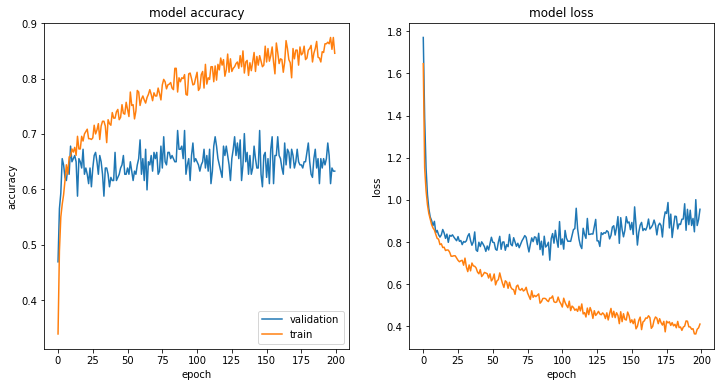

In [11]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='validation')
plt.plot(history.history['accuracy'], label='train')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Our goal is for the deep model to do at least as well as logistic regression, which reached 58-62% (depending on the method).
Here we do better, reaching up to 75% accuracy, passing the unofficial threshold for acceptable BCI performance. We expect the deep model will be useful in other ways too.

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [ ]:
# Load the 'best' model from disk.
from tensorflow.keras.models import load_model
model = load_model(datadir / 'converted' / (SESS_ID + '_model_best.h5'))
# model.summary()

### First convolutional layer
The first convolutional layer is simply performing time-domain convolution. Interpreting this layer is similar to visualizing filter characteristics.

In [ ]:
filters = model.layers[0].get_weights()[0]
t = ax_info['timestamps']

# Impulse response
impulse = np.zeros_like(t)
impulse[int(len(t)//2)] = 1.0
imp_conv = scipy.signal.convolve(impulse, filters, 'same')

In [ ]:
filters, biases = model.layers[2].get_weights()
# filters is shape 18 (kernel length), 64 (input sources), 20 (filters)
l_kernel, n_sources, n_filters = filters.shape
# For visualization, scale the filters to be between 0 and 1.
filters = np.copy(filters)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

for filt_ix in range(n_filters):
    x = np.arange(l_kernel) + filt_ix * l_kernel
    for in_ix in range(n_sources):
        fig.add_trace(go.Scatter(x=x, y=filters[:, in_ix, filt_ix] - in_ix,
                                 mode='lines', line={'color': 'black'},
                                 hoverinfo='skip', name=''))
enable_plotly_in_cell(IN_COLAB)
iplot(fig, config=plotly_cfg)

In [ ]:
# Do a PCA on the filter kernels to give us an idea if we're using too few, too many.
exp_var = []
from sklearn.decomposition import PCA
for source_ix in range(filters.shape[1]):
    pca = PCA().fit(filters[:, source_ix, :].T)
    exp_var.append(100 * np.cumsum(pca.explained_variance_ratio_))
fig = plt.figure(figsize=(8, 5), facecolor='white')
plt.plot(np.vstack(exp_var).T)
plt.xlabel('N Filters')
plt.ylabel('Cum. VAF (%)')
plt.show()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

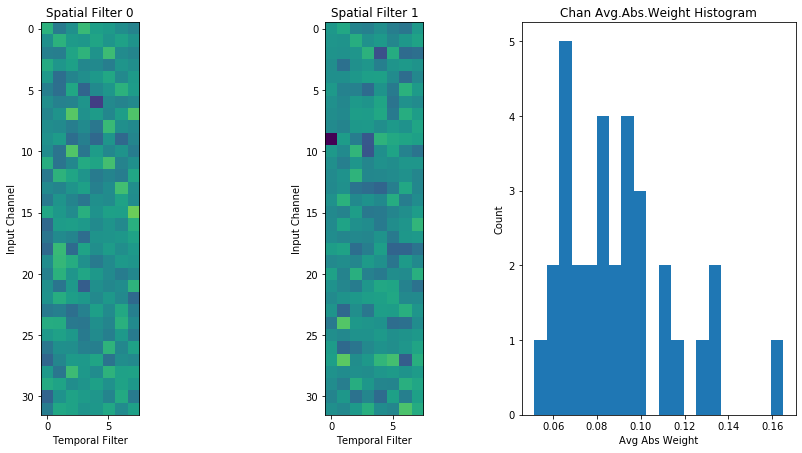

In [12]:
spatial_filter = np.squeeze(model.layers[2].get_weights()[0])
D = spatial_filter.shape[-1]
sp_dim = int(np.ceil(np.sqrt(D)))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12), facecolor='white')
for depth_ix in range(D):
    plt.subplot(sp_dim, sp_dim+1, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin)
    plt.title('Spatial Filter {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()
plt.subplot(sp_dim, sp_dim+1, D+1)
avg_abs_weight = np.mean(np.mean(np.abs(spatial_filter), axis=1), axis=-1)
# plt.bar(np.arange(spatial_filter.shape[0]), avg_abs_weight)
# plt.xlabel('Channel ID')
# plt.ylabel('Avg Abs Weight')
plt.hist(avg_abs_weight, 20)
plt.xlabel('Avg Abs Weight')
plt.ylabel('Count')
plt.title('Chan Avg.Abs.Weight Histogram')
plt.tight_layout()
plt.show()

There is a single channel (id-9) that has the most weight, then another sub-group of a small number of channels with intermediate weights, and the rest with low weights.

# Maximum activations

For the remaining layers, it's difficult to conceptualize what data they represent simply by looking at their weights.
A more useful representation is to visualize an input that would maximize activation of a given filter. How do we do that?

Remembering back to the manual step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function. Now we know the weights but we want to find the _inputs_ that _maximize_ some other function related to the activation (a.k.a. output) of a filter. The new functions isn't really a 'loss', but we're going to use the same training framework so we'll hijack the loss function. A common loss function for this task is to simply take the Mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to modify the input (i.e., step the input up the gradients). Repeat with the new input until we have an input that maximizes our 'loss'.

In [ ]:
from tensorflow.keras import backend as K
LAYER_IX = 6  # [2, 6, 10, 14]
FILTER_IX = 0
N_STEPS = 200

max_model = tf.keras.Model(model.input, model.layers[LAYER_IX].output[:, :, FILTER_IX])
input_data = tf.convert_to_tensor(np.random.randn(*X.shape[1:]).astype(np.float32)[None, :, :])
for step_ix in range(N_STEPS):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        filter_act = max_model(input_data)
        loss_value = K.mean(filter_act)
    grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
    input_data += grads
print(loss_value.numpy())

In [ ]:
max_activation = input_data.numpy()[0]
plt.plot(max_activation[:, ch_ids[:3]])
plt.show()

Let's plot filter activation maximization signals for ~4 filters from each of the CNN layers.
This uses a [helper function from the repository](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/indl/cnn_helper_1D.py#L77-L149).

In [ ]:
from indl.cnn_helper_1D import visualize_layer, _stitch_filters
layer_idx = 10  # [2, 6, 10, 14]
max_acts = visualize_layer(model, layer_idx,
                           upsampling_steps=1, upsampling_factor=1,
                           filter_range=(0, 20),
                           output_dim=(701, model.get_input_shape_at(0)[-1]))
stitched_data = _stitch_filters(max_acts)

import matplotlib.pyplot as plt

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))

fig = plt.figure(figsize=(10, 6))
for chan_ix in ch_ids[:3]:
    plt.plot(stitched_data[:, :, chan_ix], color=next(colour_codes))
plt.show()

### Class Activation Maximization
If we extend our reasoning from filter activations down to the very last layer, and we choose a 'loss' that maximizes one class and minimizes the others, we can plot maximization signals for each of the 3 output classes.

In [ ]:
layer_idx = 20
# When processing softmax classification layer,
# second last dense layer should be converted from relu to linear.
if (layer_idx == len(model.layers) - 1) and (model.layers[-2].activation != tf.keras.activations.linear):
    model.layers[-2].activation = tf.keras.activations.linear
    import tempfile
    # Save and load the model to actually apply the change.
    tmp_path = Path(tempfile.gettempdir()) / (next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(str(tmp_path))
        model = load_model(str(tmp_path))
    finally:
        tmp_path.unlink()

In [ ]:
from indl.cnn_helper_1D import visualize_layer, _stitch_filters
max_acts = visualize_layer(model, layer_idx, loss_as_exclusive=True,
                           upsampling_steps=1, upsampling_factor=1,
                           filter_range=(0, 10),
                           output_dim=(701, model.get_input_shape_at(0)[-1]))
stitched_data = _stitch_filters(max_acts, n=2, sort_by_activation=False)

import matplotlib.pyplot as plt

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))

fig = plt.figure(figsize=(8, 5))
for chan_ix in ch_ids[:3]:
    plt.plot(stitched_data[:, :, chan_ix], color=next(colour_codes))
plt.show()

### Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
N_TRIALS = 9
test_class = 'ISI'
classes, y = np.unique(Y, return_inverse=True)
trial_ids = np.where(y == classes.tolist().index(test_class))[0]

losses_grads = []
for tr_id in trial_ids:
    input_data = tf.convert_to_tensor(X[tr_id, :, :].astype(np.float32)[None, :, :])
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        class_proba = model(input_data)
        loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
    grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
    losses_grads.append((loss_value, grads))

In [ ]:
loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.concatenate([_[1].numpy() for _ in losses_grads], axis=0)
re_ix = np.argsort(loss_vals)
_x = X[trial_ids][re_ix][:3]
_masks = grad_vals[re_ix][:3]

for tr_ix in range(3):
    plt.subplot(3, 1, tr_ix + 1)
    plt.plot(_x[tr_ix, :, ch_ids[0]])
    ax2=plt.twinx()
    ax2.plot(_masks[tr_ix, :, ch_ids[0]], 'k')

### Class Activation Maps
Class activation maps highlight the parts of the input that contribute most to each classification score.
This is similar but different to saliency mapping, and has largely replaced saliency mapping.
While we don't have any code to do class activation mapping (yet), there are a couple examples in the slides for Part 3.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [ ]:
def evaluate_model(params, verbose=0):
    print(params)
    n_temporal_filters = params.get('n_temporal_filters', 8)
    kern_length_1 = params.get('kern_length_1', 48)
    D = params.get('D', 4)
    downsamp_1 = params.get('downsamp_1', 4)
    kern_length_2 = params.get('kern_length_2', 32)  # int(kern_length_1 // downsamp_1))
    downsamp_2 = params.get('downsamp_2', 2)
    n_pointwise_filters = params.get('n_pointwise_filters', 32)
    n_last_filters = params.get('n_last_filters', 6)
    kern_length_3 = params.get('kern_length_3', 16)  # int(kern_length_2 // downsamp_2))
    downsamp_3 = params.get('downsamp_3', 2)
    norm_rate = params.get('norm_rate', 0.4)
    dropout_rate = params.get('dropout_rate', 0.4)
    l2_reg = params.get('l2_reg', 0.0005)
    epochs = params.get('epochs', 100)
    
    model = make_model(X.shape[1], X.shape[2], n_temporal_filters=n_temporal_filters, kern_length_1=kern_length_1,
                       D=D, downsamp_1=downsamp_1, kern_length_2=kern_length_2, n_pointwise_filters=n_pointwise_filters,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    min_val_loss = min(history.history['val_loss'])
    
    reset_keras(model)
    reset_keras(model)  # Just to be sure...
    
    return min_val_loss

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest


space = {
    'n_temporal_filters': scope.int(hp.quniform('n_temporal_filters', 2, 65, 4)),
    'kern_length_1': scope.int(hp.quniform('kern_length_1', 4, 64, 1)),
    'D': scope.int(hp.quniform('D', 1, 8, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 2, 9, 1)),
    'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 32, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 8, 1)),
    'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
#     'n_last_filters': scope.int(hp.quniform('n_last_filters', 2, 65, 1)),
#     'kern_length_3': scope.int(hp.quniform('kern_length_3', 4, 32, 1)),
#     'downsamp_3': scope.int(hp.quniform('downsamp_3', 2, 8, 1)),
    'norm_rate': hp.uniform('norm_rate', 0., 0.5),
    'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
    'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(0.1)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
}

trials = Trials()  # object that holds iteration results
#Do optimization
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=30, trials=trials)
print("Best Loss: {}".format(trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))